In [ ]:
# Club Mahindera datahack submission by shubham chauhan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gc
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train = train_data.copy()
test = test_data.copy()

In [3]:
#train.head()

In [4]:
#train.info()

In [5]:
# checking for missing values

#train.isnull().sum()

In [6]:
# creating functions for data prepration

def dateprep(x):
    x = x[:6]+'20'+x[6:]
    return x

In [7]:
target = train['amount_spent_per_room_night_scaled']
train.drop('amount_spent_per_room_night_scaled',axis = 1, inplace = True)
gc.collect()

18

In [8]:
#combining train and test set
df = pd.concat((train, test))

In [9]:
# working in date variables

df['booking_date'] = df['booking_date'].apply(dateprep)
df['checkin_date'] = df['checkin_date'].apply(dateprep)
df['checkout_date'] = df['checkout_date'].apply(dateprep)

df['booking_date']= pd.to_datetime(df['booking_date'], format = '%d/%m/%Y')
df['checkin_date']= pd.to_datetime(df['checkin_date'], format = '%d/%m/%Y')
df['checkout_date']= pd.to_datetime(df['checkout_date'], format = '%d/%m/%Y')

In [10]:
df.head()

reservation_id booking_date  \
0  07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...   2018-04-05   
1  03930f033646d073462b35d411616323597715ac4fc398...   2015-01-23   
2  d145a32920e6587ad95bfe299d80c0affa268220535aaf...   2015-01-28   
3  cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...   2015-05-02   
4  937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...   2015-09-02   

  checkin_date checkout_date  channel_code  main_product_code  numberofadults  \
0   2018-04-05    2018-04-06             3                  1               2   
1   2015-04-11    2015-04-16             1                  1               2   
2   2015-02-01    2015-02-05             1                  1               2   
3   2015-06-11    2015-06-16             1                  1               2   
4   2015-12-14    2015-12-19             1                  1               2   

   numberofchildren  persontravellingid  resort_region_code  resort_type_code  \
0                 0                  46                   3                 3   
1                 0                  46                   3                 3   
2                 0                  47                   1                 5   
3                 2                  46                   2                 2   
4                 0                  46                   2                 2   

   room_type_booked_code  roomnights  season_holidayed_code  \
0                      3           1                    2.0   
1                      4           5                    2.0   
2                      4           4                    2.0   
3                      3           5                    2.0   
4                      4           5                    2.0   

   state_code_residence  state_code_resort  total_pax member_age_buckets  \
0                   7.0                  3          3                  F   
1                   7.0                  5          2                  F   
2                   7.0                  1          2                  F   
3                   7.0                  2          2                  F   
4                   7.0                  2          2                  F   

   booking_type_code                                           memberid  \
0                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
1                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
2                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
3                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
4                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   

  cluster_code reservationstatusid_code  \
0            F                        C   
1            F                        A   
2            E                        A   
3            D                        A   
4            D                        A   

                                           resort_id  
0  4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...  
1  39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...  
2  535fa30d7e25dd8a49f1536779734ec8286108d115da50...  
3  d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...  
4  d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...

In [11]:
# function for cleaning newly created columns
def date_diff(d1, d2):
    d1 = pd.to_datetime(d1)
    d2 = pd.to_datetime(d2)
    days = (d2-d1).days
    return days

In [12]:
# generating some features

df['weekday'] =df['checkin_date'].apply(lambda x: x.weekday())

df['month'] =df['checkin_date'].apply(lambda x: x.strftime("%m"))

df['total_passengers'] = df['numberofadults']+df['numberofchildren']

df['no_days_spend'] = df.apply(lambda x: date_diff(x['checkin_date'], x['checkout_date']), axis=1)
df['no_days_before_booked'] = df.apply(lambda x: date_diff(x['booking_date'], x['checkin_date']), axis=1)


In [13]:
df.head()

reservation_id booking_date  \
0  07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...   2018-04-05   
1  03930f033646d073462b35d411616323597715ac4fc398...   2015-01-23   
2  d145a32920e6587ad95bfe299d80c0affa268220535aaf...   2015-01-28   
3  cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...   2015-05-02   
4  937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...   2015-09-02   

  checkin_date checkout_date  channel_code  main_product_code  numberofadults  \
0   2018-04-05    2018-04-06             3                  1               2   
1   2015-04-11    2015-04-16             1                  1               2   
2   2015-02-01    2015-02-05             1                  1               2   
3   2015-06-11    2015-06-16             1                  1               2   
4   2015-12-14    2015-12-19             1                  1               2   

   numberofchildren  persontravellingid  resort_region_code  resort_type_code  \
0                 0                  46                   3                 3   
1                 0                  46                   3                 3   
2                 0                  47                   1                 5   
3                 2                  46                   2                 2   
4                 0                  46                   2                 2   

   room_type_booked_code  roomnights  season_holidayed_code  \
0                      3           1                    2.0   
1                      4           5                    2.0   
2                      4           4                    2.0   
3                      3           5                    2.0   
4                      4           5                    2.0   

   state_code_residence  state_code_resort  total_pax member_age_buckets  \
0                   7.0                  3          3                  F   
1                   7.0                  5          2                  F   
2                   7.0                  1          2                  F   
3                   7.0                  2          2                  F   
4                   7.0                  2          2                  F   

   booking_type_code                                           memberid  \
0                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
1                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
2                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
3                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   
4                  1  3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...   

  cluster_code reservationstatusid_code  \
0            F                        C   
1            F                        A   
2            E                        A   
3            D                        A   
4            D                        A   

                                           resort_id  weekday month  \
0  4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...        3    04   
1  39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...        5    04   
2  535fa30d7e25dd8a49f1536779734ec8286108d115da50...        6    02   
3  d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...        3    06   
4  d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...        0    12   

   total_passengers  no_days_spend  no_days_before_booked  
0                 2              1                      0  
1                 2              5                     78  
2                 2              4                      4  
3                 4              5                     40  
4                 2              5                    103

In [14]:
#checking unique values in the columns having missing values

print("no of unique values in season_holidayed are ", df.season_holidayed_code.nunique(), '\nunique values in season_holidayed are ',df.season_holidayed_code.unique())

print("no of unique values in state_code_residence are ", df.state_code_residence.nunique(), '\nunique values in state_code_residence are ',df.state_code_residence.unique())


no of unique values in season_holidayed are  4 
unique values in season_holidayed are  [ 2.  3.  4.  1. nan]
no of unique values in state_code_residence are  37 
unique values in state_code_residence are  [ 7.  8.  2.  5.  6.  3.  4.  1.  9. 14. nan 25. 15. 12. 10. 28. 24. 23.
 20. 11. 13. 21. 18. 16. 26. 27. 22. 19. 31. 34. 32. 30. 33. 29. 37. 35.
 36. 38.]


### Missing value treatment

In [15]:
# There are missing values in season_holidayed_code and state_code_residece
# Filling missing values
#df['state_code_residence'].astype(object, inplace = True)
df['season_holidayed_code'].fillna('other', inplace = True)
df['state_code_residence'].fillna('other', inplace = True)

In [16]:
#checking no. of unique values in each column
print('no. of unique values in each column \n')
for col in df.columns:
    print(col,' ',df[col].nunique())

no. of unique values in each column 

reservation_id   488189
booking_date   1624
checkin_date   1534
checkout_date   1533
channel_code   3
main_product_code   5
numberofadults   29
numberofchildren   13
persontravellingid   6
resort_region_code   3
resort_type_code   7
room_type_booked_code   6
roomnights   48
season_holidayed_code   5
state_code_residence   38
state_code_resort   11
total_pax   18
member_age_buckets   10
booking_type_code   2
memberid   144823
cluster_code   6
reservationstatusid_code   4
resort_id   32
weekday   7
month   12
total_passengers   34
no_days_spend   17
no_days_before_booked   141


In [17]:
# Pre processing categorical variables

# one hot encoding

df = pd.get_dummies(df, columns = ['channel_code', 'main_product_code', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code',
                                  'state_code_resort', 'member_age_buckets', 'booking_type_code', 'cluster_code', 'reservationstatusid_code', 'month', 'weekday'])


#columns = ['channel_code', 'main_product_code', 'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code',
#                                  'state_code_resort', 'member_age_buckets', 'booking_type_code', 'cluster_code', 'reservationstatusid_code', 'resort_id', 'state_code_residence', 'month']

# label encoding
lb = LabelEncoder()

#for col in columns:
 #   df[col] = lb.fit_transform(df[col].astype(str))

df['resort_id'] = lb.fit_transform(df['resort_id'])

df['state_code_residence'] = lb.fit_transform(df['state_code_residence'].astype(str))


In [18]:
#df.head()

In [19]:
#droping useless columns
df.drop(['reservation_id', 'memberid'], axis = 1, inplace = True)

In [20]:
#droping date columns
df.drop(['booking_date', 'checkin_date', 'checkout_date'], axis = 1, inplace = True)

In [21]:
# split df back to train and test

train = df.iloc[:len(train), :]
test = df.iloc[len(train):, :]

train['amount_spent_per_room_night_scaled'] = target

c:\users\shubham\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
#train.head()

#### checking for correlation

In [25]:
features = (train.drop('amount_spent_per_room_night_scaled',  axis = 1)).columns.tolist()
target = train['amount_spent_per_room_night_scaled'].name
correlations = {}
for f in features:
    data_temp = train[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [26]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

Value
no_days_spend vs amount_spent_per_room_night_sc... -0.198800
total_passengers vs amount_spent_per_room_night...  0.159418
numberofadults vs amount_spent_per_room_night_s...  0.150047
total_pax vs amount_spent_per_room_night_scaled     0.143056
channel_code_1 vs amount_spent_per_room_night_s... -0.089105
resort_type_code_3 vs amount_spent_per_room_nig... -0.083655
resort_region_code_3 vs amount_spent_per_room_n... -0.080667
channel_code_3 vs amount_spent_per_room_night_s...  0.074726
season_holidayed_code_1.0 vs amount_spent_per_r...  0.072610
state_code_resort_4 vs amount_spent_per_room_ni... -0.071268
state_code_resort_6 vs amount_spent_per_room_ni...  0.069844
room_type_booked_code_2 vs amount_spent_per_roo...  0.061283
main_product_code_1 vs amount_spent_per_room_ni...  0.059578
state_code_resort_5 vs amount_spent_per_room_ni... -0.055375
cluster_code_A vs amount_spent_per_room_night_s... -0.053557
main_product_code_4 vs amount_spent_per_room_ni... -0.053149
state_code_resort_3 vs amount_spent_per_room_ni... -0.052417
roomnights vs amount_spent_per_room_night_scaled    0.050379
cluster_code_C vs amount_spent_per_room_night_s...  0.048528
state_code_resort_7 vs amount_spent_per_room_ni...  0.048528
resort_region_code_1 vs amount_spent_per_room_n...  0.048302
numberofchildren vs amount_spent_per_room_night...  0.047827
season_holidayed_code_4.0 vs amount_spent_per_r... -0.047635
state_code_residence vs amount_spent_per_room_n... -0.047382
main_product_code_3 vs amount_spent_per_room_ni... -0.046245
room_type_booked_code_3 vs amount_spent_per_roo... -0.045996
resort_type_code_1 vs amount_spent_per_room_nig...  0.045968
resort_id vs amount_spent_per_room_night_scaled    -0.045387
resort_type_code_5 vs amount_spent_per_room_nig...  0.045353
month_02 vs amount_spent_per_room_night_scaled     -0.044971
...                                                      ...
cluster_code_D vs amount_spent_per_room_night_s... -0.013995
reservationstatusid_code_B vs amount_spent_per_...  0.012839
room_type_booked_code_5 vs amount_spent_per_roo...  0.012682
month_10 vs amount_spent_per_room_night_scaled      0.011956
weekday_2 vs amount_spent_per_room_night_scaled    -0.011459
reservationstatusid_code_C vs amount_spent_per_... -0.011349
month_04 vs amount_spent_per_room_night_scaled      0.011310
member_age_buckets_A vs amount_spent_per_room_n... -0.010977
month_06 vs amount_spent_per_room_night_scaled      0.009729
state_code_resort_9 vs amount_spent_per_room_ni... -0.008999
month_11 vs amount_spent_per_room_night_scaled     -0.008175
month_01 vs amount_spent_per_room_night_scaled     -0.007644
cluster_code_B vs amount_spent_per_room_night_s... -0.006365
resort_type_code_0 vs amount_spent_per_room_nig... -0.006082
resort_type_code_4 vs amount_spent_per_room_nig...  0.005359
cluster_code_F vs amount_spent_per_room_night_s... -0.005319
season_holidayed_code_other vs amount_spent_per...  0.005259
month_08 vs amount_spent_per_room_night_scaled      0.004742
month_07 vs amount_spent_per_room_night_scaled     -0.003330
weekday_6 vs amount_spent_per_room_night_scaled    -0.003193
member_age_buckets_C vs amount_spent_per_room_n...  0.003002
resort_type_code_2 vs amount_spent_per_room_nig... -0.002998
member_age_buckets_I vs amount_spent_per_room_n... -0.002384
reservationstatusid_code_D vs amount_spent_per_... -0.001481
reservationstatusid_code_A vs amount_spent_per_... -0.001265
member_age_buckets_F vs amount_spent_per_room_n... -0.001224
main_product_code_7 vs amount_spent_per_room_ni... -0.001183
weekday_3 vs amount_spent_per_room_night_scaled     0.001068
member_age_buckets_J vs amount_spent_per_room_n... -0.000873
room_type_booked_code_6 vs amount_spent_per_roo...  0.000871

[91 rows x 1 columns]

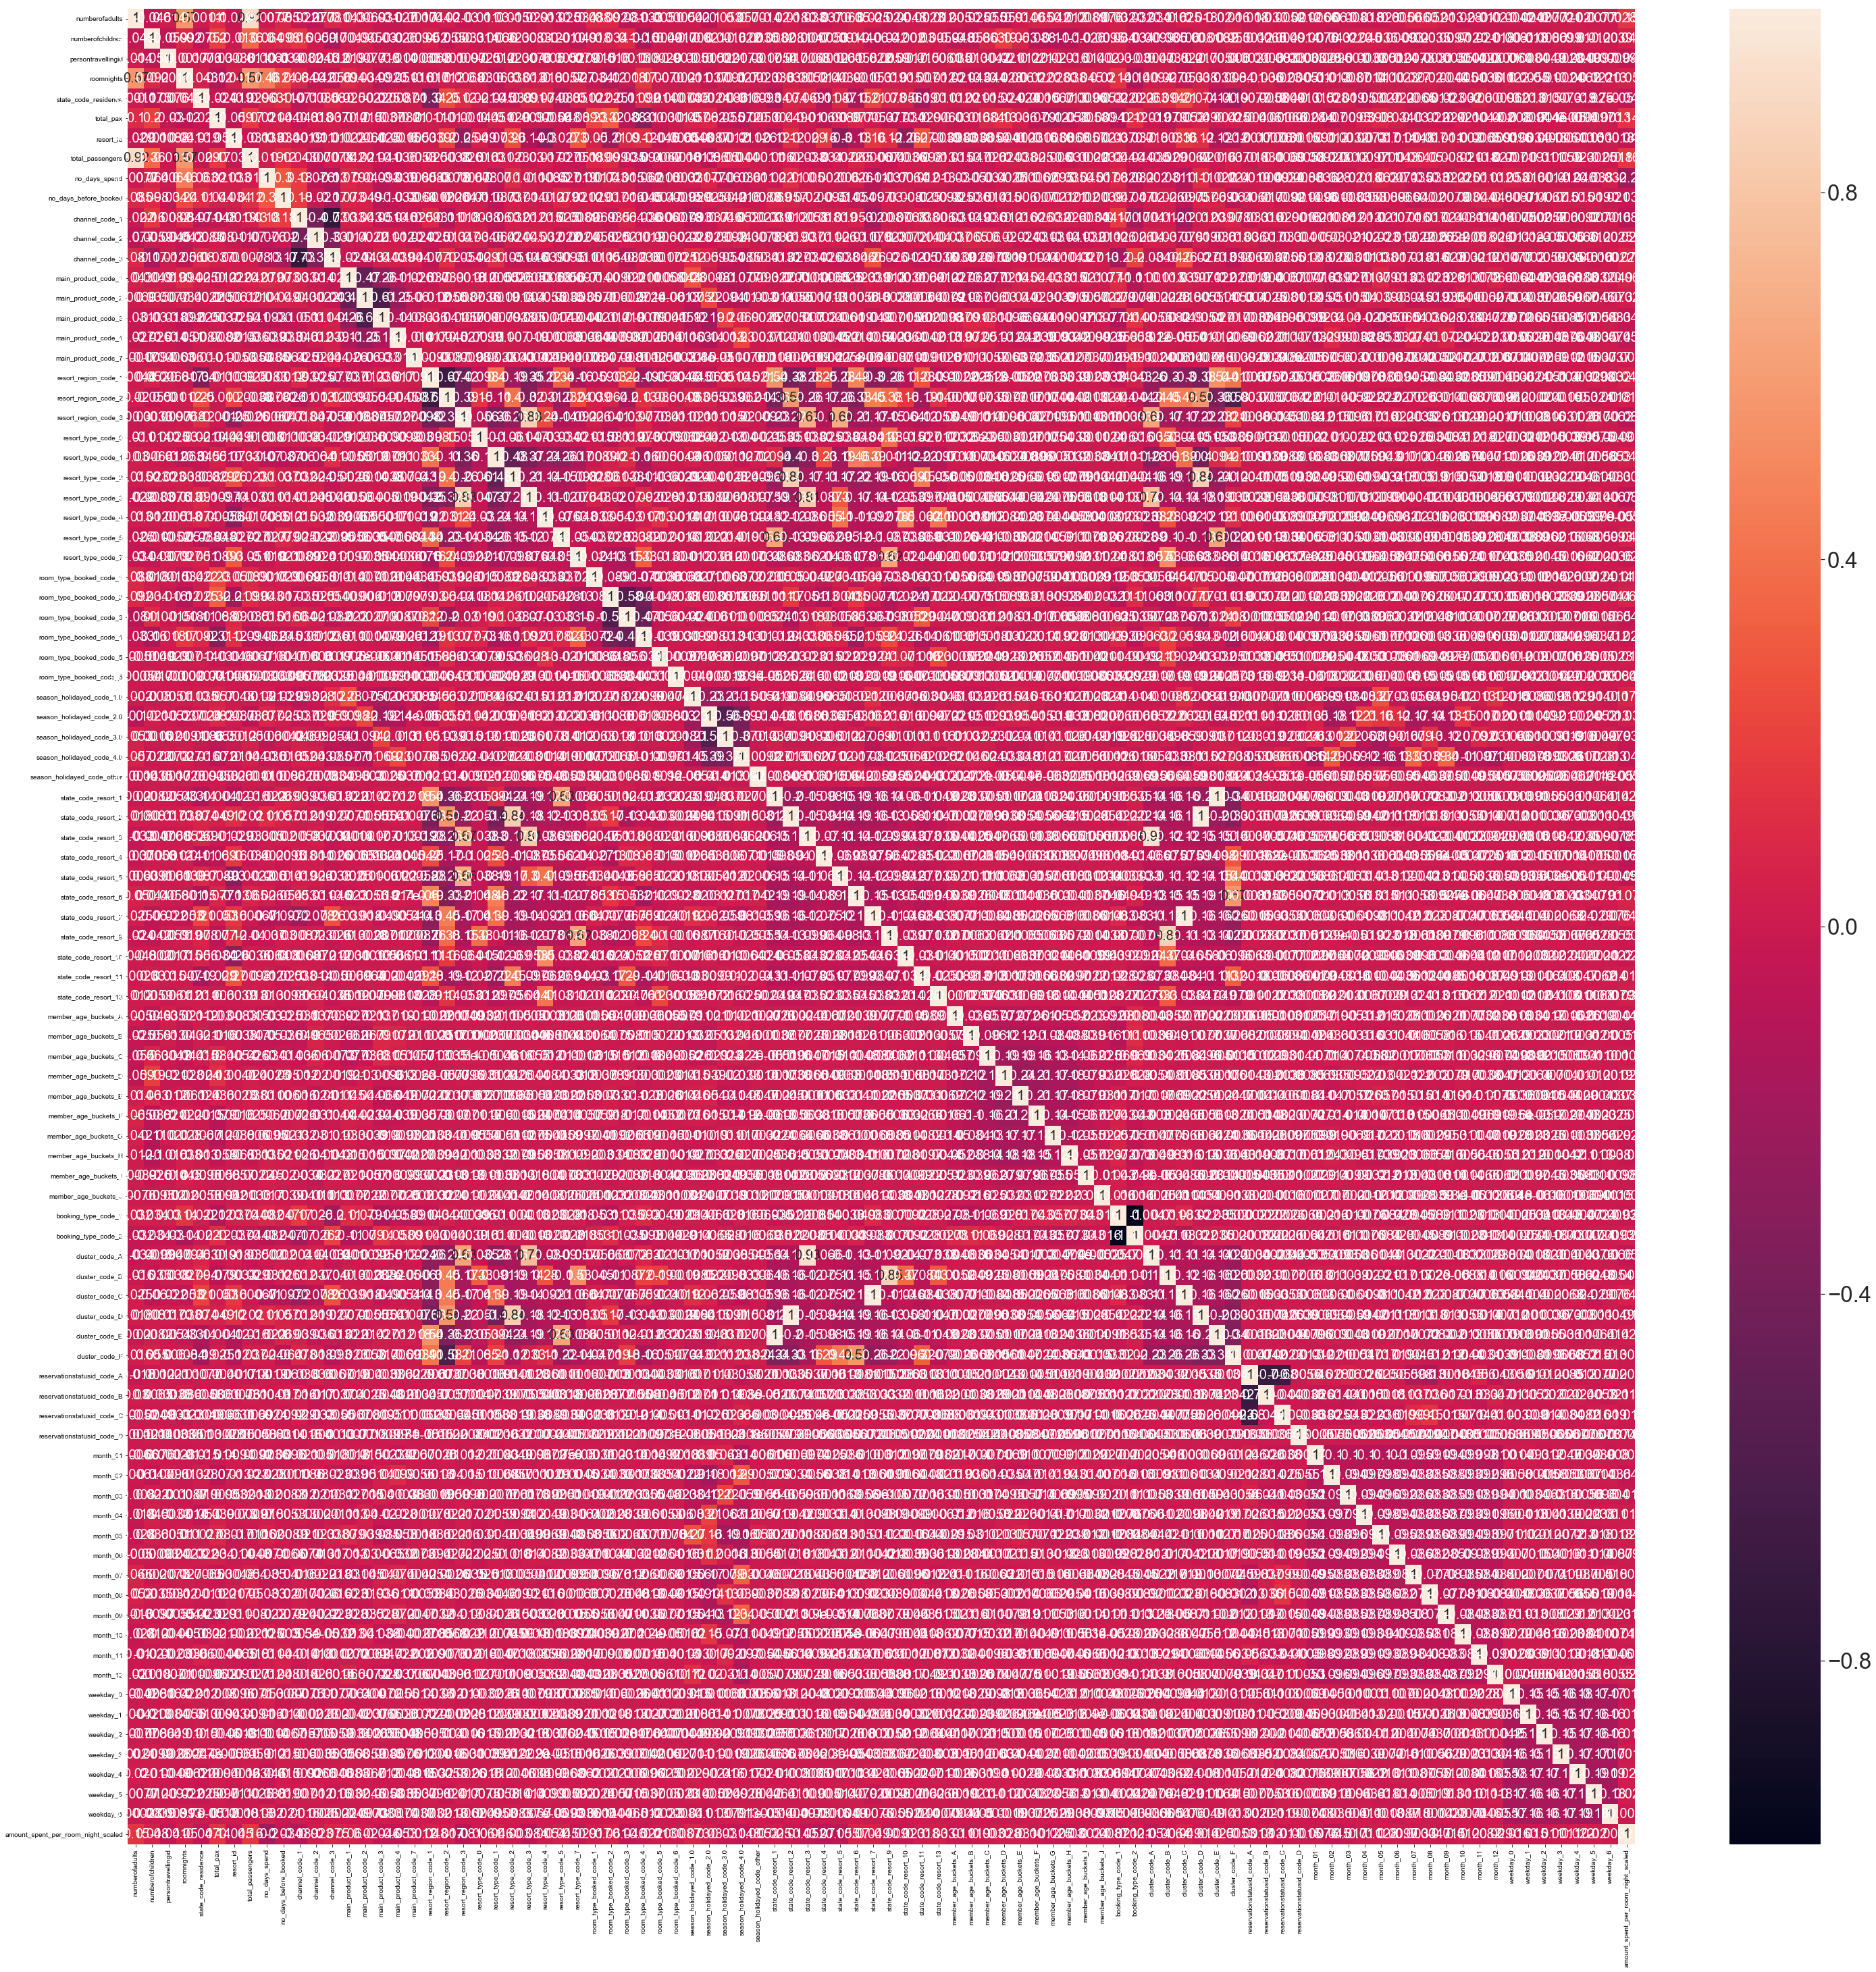

In [27]:
# ploting heat map for correlation
import seaborn as sns

train_df = train.copy()

fig, ax = plt.subplots(figsize=(50, 50))
corr = train_df.corr()
sns.set(font_scale=3)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, annot_kws={"size": 20} )

In [28]:
# droping variables having correlation greater than 0.5

correlated_features = [] 
for i in range(len(corr .columns)):  
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.5:
            colname = corr.columns[i]
            correlated_features.append(colname)
print(correlated_features)    

['roomnights', 'total_passengers', 'total_passengers', 'channel_code_3', 'main_product_code_3', 'resort_region_code_2', 'resort_type_code_3', 'room_type_booked_code_3', 'season_holidayed_code_3.0', 'state_code_resort_1', 'state_code_resort_1', 'state_code_resort_2', 'state_code_resort_2', 'state_code_resort_3', 'state_code_resort_3', 'state_code_resort_5', 'state_code_resort_9', 'state_code_resort_10', 'booking_type_code_2', 'cluster_code_A', 'cluster_code_A', 'cluster_code_A', 'cluster_code_B', 'cluster_code_B', 'cluster_code_C', 'cluster_code_D', 'cluster_code_D', 'cluster_code_D', 'cluster_code_E', 'cluster_code_E', 'cluster_code_E', 'cluster_code_F', 'cluster_code_F', 'reservationstatusid_code_B', 'reservationstatusid_code_C']


In [29]:
correlated_features = list(correlated_features)
train_df.drop(correlated_features, axis = 1, inplace = True)
test.drop(correlated_features, axis = 1, inplace = True)

c:\users\shubham\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
#train_df.head()

In [31]:
y = train_df['amount_spent_per_room_night_scaled']
x = train_df.drop('amount_spent_per_room_night_scaled', axis = 1)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=4)

## Model Building

In [34]:
# making a lasso model

from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.005, random_state = 0))
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)


RMSE : 102.2222589746333


#### Elastic net

In [39]:
# making an Elastic Net model

from sklearn.linear_model import ElasticNet

enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=.9, random_state=3))
enet.fit(x_train, y_train)
y_pred = enet.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)

RMSE : 102.18641752439508


#### Gboost

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

# making a gradint boosting model
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)

RMSE : 99.52040219319952


#### LightGBM

In [41]:
# light gradient boosting
import lightgbm as lgb

lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)

RMSE : 99.11256196574078


#### XGBoost

In [44]:
# XG BOOST
import xgboost as xgb

xgb = xgb.XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)

RMSE : 99.58129157851475


### stacking of Models

In [42]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.base import TransformerMixin
from sklearn.base import clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

In [43]:
averaged_models = AveragingModels(models = (enet, gbr, lasso))
averaged_models.fit(x_train, y_train)
y_pred = averaged_models.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse*100)

RMSE : 100.82631457704822


In [45]:
# predicting for the test data

xgb_pred = xgb.predict(test)
lgb_pred = lgb.predict(test)
stacked_pred = averaged_models.predict(test)

In [46]:
# boosting the predictions

predictions = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15


In [47]:
sample = pd.read_csv("sample_submission.csv")
sub = sample.copy()

sub['reservation_id'] = test_data.reservation_id
sub['amount_spent_per_room_night_scaled'] = predictions

In [48]:
sub.to_csv("stacked_2.csv", index = False)